In [1]:
"""
NV-13C DDRF (Dynamical Decoupling with RF) Simulation
Converted from MATLAB to Python
Updated: 08/13/2025 by Paul Junghyun Lee
Converted to Python: 2025

This version includes RF frequency scanning for nuclear spin manipulation.
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
import time


In [2]:

# Start timing
start_time = time.time()

# Define dimension, pauli matrices
i = 1j  # imaginary unit
sx = 1/np.sqrt(2) * np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]], dtype=complex)
sy = 1/np.sqrt(2)/i * np.array([[0, 1, 0], [-1, 0, 1], [0, -1, 0]], dtype=complex)
sz = np.array([[1, 0, 0], [0, 0, 0], [0, 0, -1]], dtype=complex)
I = np.eye(3, dtype=complex)

# Rotation matrix projected into 2 level system
Sxp = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]], dtype=complex)
Sxm = np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0]], dtype=complex)

Syp = 1/i * np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 0]], dtype=complex)
Sym = 1/i * np.array([[0, 0, 0], [0, 0, 1], [0, -1, 0]], dtype=complex)

# Pauli basis for 13C nuclear spin
Ix = 1/2 * np.array([[0, 0, 1], [0, 0, 0], [1, 0, 0]], dtype=complex)
Iy = 1/2 * 1/i * np.array([[0, 0, 1], [0, 0, 0], [-1, 0, 0]], dtype=complex)
Iz = 1/2 * np.array([[1, 0, 0], [0, 0, 0], [0, 0, -1]], dtype=complex)



In [3]:

def UO(B1, B2, a, D1, D2):
    """
    Generate NV spin gate function
    
    Parameters:
    -----------
    B1 : float
        Drive amplitude for |0⟩↔|+1⟩ transition
    B2 : float
        Drive amplitude for |0⟩↔|-1⟩ transition
    a : float
        Rotation angle
    D1, D2 : float
        Microwave phases
    
    Returns:
    --------
    U : ndarray (3x3)
        Rotation matrix for NV spin-1 system
    """
    Omega_sq = B1**2 + B2**2
    
    if Omega_sq == 0:
        return np.eye(3, dtype=complex)
    
    Omega = np.sqrt(Omega_sq)
    
    U = np.array([
        [(B2**2 + B1**2*np.cos(a))/Omega_sq, 
         -1j*B1*np.exp(-1j*D1)*np.sin(a)/Omega, 
         ((-1+np.cos(a))*B1*B2*np.exp(-1j*(D1-D2)))/Omega_sq],
        
        [-1j*B1*np.exp(1j*D1)*np.sin(a)/Omega, 
         np.cos(a), 
         -1j*B2*np.exp(1j*D2)*np.sin(a)/Omega],
        
        [((-1+np.cos(a))*B1*B2*np.exp(1j*(D1-D2)))/Omega_sq, 
         -1j*B2*np.exp(-1j*D2)*np.sin(a)/Omega, 
         (B1**2 + B2**2*np.cos(a))/Omega_sq]
    ], dtype=complex)
    
    return U



In [4]:

def NU0(Al, Ap, tau, Ng, B=440.1):
    """
    Generate nuclear spin gate function using dynamical decoupling
    
    Parameters:
    -----------
    Al : float
        Parallel hyperfine coupling (MHz)
    Ap : float
        Perpendicular hyperfine coupling (MHz)
    tau : float
        Evolution time (us)
    Ng : int
        Number of pi pulses
    B : float
        Magnetic field (G)
    
    Returns:
    --------
    NU : ndarray (9x9)
        Nuclear spin gate operator
    """
    # Define operators (local scope)
    i = 1j
    sz_local = np.array([[1, 0, 0], [0, 0, 0], [0, 0, -1]], dtype=complex)
    I_local = np.eye(3, dtype=complex)
    Ix_local = 1/2 * np.array([[0, 0, 1], [0, 0, 0], [1, 0, 0]], dtype=complex)
    Iz_local = 1/2 * np.array([[1, 0, 0], [0, 0, 0], [0, 0, -1]], dtype=complex)
    
    # Single Q gates
    U180xp = UO(1, 0, np.pi/2, 0, 0)
    
    gammaN = 2*np.pi*1.071e-3  # MHz/G
    NU = np.kron(I_local, I_local)
    
    # Hamiltonian
    ham = (Al*np.kron(sz_local, Iz_local) + 
           Ap*np.kron(sz_local, Ix_local) + 
           B*gammaN*np.kron(I_local, Iz_local))
    
    # Diagonalize Hamiltonian
    eigvals, eigvecs = np.linalg.eig(ham)
    E = np.diag(eigvals)
    U_H = eigvecs.T.conj()
    
    # Free evolution operators
    U_e = eigvecs @ expm(-1j*E*tau) @ U_H
    U_e2 = eigvecs @ expm(-1j*E*tau/2) @ U_H
    
    # Build sequence
    NU = U_e2 @ NU
    
    for h in range(Ng-1):
        NU = U_e @ np.kron(U180xp, I_local) @ NU
    
    NU = U_e2 @ np.kron(U180xp, I_local) @ NU
    
    return NU


def PartialTrace(rho, system):
    """
    Compute partial trace over specified system
    
    Parameters:
    -----------
    rho : ndarray (9x9)
        Density matrix of composite system
    system : int
        Which system to trace out (1=first, 2=second)
    
    Returns:
    --------
    rho_reduced : ndarray (3x3)
        Reduced density matrix
    """
    if system == 1:
        # Trace out first system (NV spin)
        rho_reduced = np.zeros((3, 3), dtype=complex)
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    rho_reduced[i, j] += rho[k*3+i, k*3+j]
    elif system == 2:
        # Trace out second system (nuclear spin)
        rho_reduced = np.zeros((3, 3), dtype=complex)
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    rho_reduced[i, j] += rho[i*3+k, j*3+k]
    else:
        raise ValueError("system must be 1 or 2")
    
    return rho_reduced



In [5]:

# Define sweep parameters
Sweep = 5001
N = Sweep
B = 440.1  # Magnetic field [G]

# 13C nuclear spin parameters
gammaN = 2*np.pi*1.0705e-3  # MHz/G
Al = 2*np.pi*(-0.400)  # MHz, A_|| hyperfine term (DIFFERENT from first code!)
Ap = 2*np.pi*0.290     # MHz, A_perp hyperfine term (DIFFERENT from first code!)

ohm = 60E-3  # MHz (DIFFERENT: 60 instead of 50)
w0 = B*gammaN

w1 = np.sqrt((Ap**2) + ((w0-Al)**2))
w2 = np.sqrt((Ap**2) + ((w0+Al)**2))

T = 28  # sweep tau [us]
t = np.linspace(0, T, N)
freq = 2*np.pi*np.linspace(0E-3, 500E-3, N)  # MHz (DIFFERENT: 0-500 instead of 300-700)
n = 8  # number of pi pulses (DIFFERENT: 8 instead of 16)

# Define gate operations
# Single Q ms=+1
U090xp = UO(1, 0, np.pi/4, 0, 0)
U090xmp = UO(1, 0, -np.pi/4, 0, 0)
U090yp = UO(1, 0, np.pi/4, np.pi/2, 0)
U090ymp = UO(1, 0, -np.pi/4, np.pi/2, 0)
U180xp = UO(1, 0, np.pi/2, 0, 0)
U180xmp = UO(1, 0, -np.pi/2, 0, 0)
U180yp = UO(1, 0, np.pi/4, np.pi/2, 0)
U180ymp = UO(1, 0, -np.pi/4, np.pi/2, 0)

# Single Q ms=-1
U090xm = UO(0, 1, np.pi/4, 0, 0)
U090xmm = UO(0, 1, -np.pi/4, 0, 0)
U180xm = UO(0, 1, np.pi/2, 0, 0)
U180xmm = UO(0, 1, -np.pi/2, 0, 0)

# Define initial states
irho_p = np.array([[1, 0, 0], [0, 0, 0], [0, 0, 0]], dtype=complex)
irho_m = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 1]], dtype=complex)
irho_z = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]], dtype=complex)
irho_mix = np.array([[1/2, 0, 0], [0, 1/2, 0], [0, 0, 0]], dtype=complex)
irho_Z = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 1]], dtype=complex)
irho_MIX = np.array([[1/2, 0, 0], [0, 0, 0], [0, 0, 1/2]], dtype=complex)

# Initial combined state
irho = np.kron(irho_z, irho_MIX)

# Initialization
rho_0 = np.kron(U090xm, I) @ irho @ np.kron(U090xm, I).T.conj()

print("=" * 60)
print("NV-13C DDRF Simulation with RF Frequency Scanning")
print("=" * 60)
print(f"Magnetic field: {B} G")
print(f"Hyperfine coupling: A|| = {Al/(2*np.pi):.4f} MHz, A⊥ = {Ap/(2*np.pi):.4f} MHz")
print(f"RF amplitude: {ohm} MHz")
print(f"Number of π pulses: {n}")
print(f"Frequency range: 0 - 500 kHz")
print("=" * 60)
print("\nStarting RF frequency sweep simulation...")

# Main DDRF simulation loop with RF frequency scanning
Sa = np.zeros(N)
for h in range(N):
    w3 = (w2 + w1) / 2
    
    # DIFFERENT HAMILTONIAN: Using RF driving Hamiltonian
    ham = ((w0-freq[h])*np.kron(irho_z, Iz) + 
           (w1-freq[h])*np.kron(irho_m, Iz) + 
           ohm*np.kron(I, Ix))
    
    # Diagonalize Hamiltonian
    eigvals, eigvecs = np.linalg.eig(ham)
    E = np.diag(eigvals)
    U_H = eigvecs.T.conj()
    
    # DIFFERENT: Time is fixed based on w0
    t[h] = 2 * (2*np.pi/w0)  # pi pulse time
    tau = t[h]
    
    # Free evolution unitary operators
    U_e2 = eigvecs @ expm(-1j*E*t[h]/2) @ U_H  # for tau/2
    U_e = eigvecs @ expm(-1j*E*t[h]) @ U_H     # for tau
    
    rho_1 = U_e2 @ rho_0 @ U_e2.T.conj()  # first tau/2
    rho_1c = rho_1.copy()
    
    # CPMG sequence
    for k in range(n-1):
        rho_1c = (U_e @ np.kron(U180xm, I) @ rho_1c @ 
                  np.kron(U180xm, I).T.conj() @ U_e.T.conj())
    
    rho_2 = (U_e2 @ np.kron(U180xm, I) @ rho_1c @ 
             np.kron(U180xm, I).T.conj() @ U_e2.T.conj())
    rho_3 = np.kron(U090xmm, I) @ rho_2 @ np.kron(U090xmm, I).T.conj()
    
    Sa[h] = np.real(np.trace(irho_z @ PartialTrace(rho_3, 2)))
    
    if (h+1) % 500 == 0:
        print(f"Progress: {h+1}/{N}")


NV-13C DDRF Simulation with RF Frequency Scanning
Magnetic field: 440.1 G
Hyperfine coupling: A|| = -0.4000 MHz, A⊥ = 0.2900 MHz
RF amplitude: 0.06 MHz
Number of π pulses: 8
Frequency range: 0 - 500 kHz

Starting RF frequency sweep simulation...
Progress: 500/5001
Progress: 1000/5001
Progress: 1500/5001
Progress: 2000/5001
Progress: 2500/5001
Progress: 3000/5001
Progress: 3500/5001
Progress: 4000/5001
Progress: 4500/5001
Progress: 5000/5001


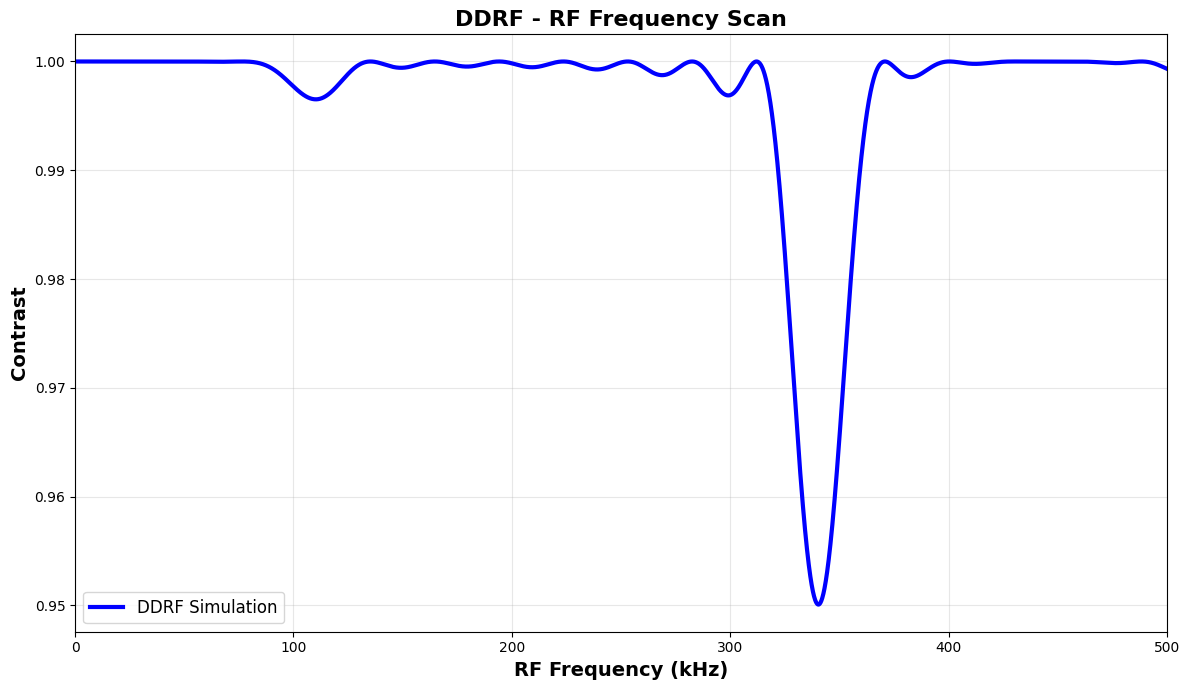

In [6]:

# Plot RF frequency scan results
plt.figure(figsize=(12, 7))
freq_kHz = freq * 1000 / (2*np.pi)  # Convert to kHz
plt.plot(freq_kHz, Sa, 'b-', linewidth=3, label='DDRF Simulation')
plt.xlabel('RF Frequency (kHz)', fontsize=14, fontweight='bold')
plt.ylabel('Contrast', fontsize=14, fontweight='bold')
plt.title('DDRF - RF Frequency Scan', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xlim([0, 500])
plt.legend(fontsize=12)
plt.tight_layout()


In [7]:

# Calculate expected resonance frequencies
wm = (w0 - Al/2)/(2*np.pi) - 7*(2*np.pi/(2*tau))/(2*np.pi)
wm2 = (w0 - Al/2)/(2*np.pi) - 9*(2*np.pi/(2*tau))/(2*np.pi)
print(f"\nExpected resonance frequencies:")
print(f"  wm (7th order): {wm*1000:.2f} kHz")
print(f"  wm2 (9th order): {wm2*1000:.2f} kHz")

# Find minimum (optimal frequency)
min_idx = np.argmin(Sa)
min_val = Sa[min_idx]
tau = t[min_idx]

print(f"\nMinimum contrast found at:")
print(f"  Index: {min_idx}")
print(f"  Value: {min_val:.6f}")
print(f"  Optimal frequency: {freq_kHz[min_idx]:.2f} kHz")
print(f"  Corresponding tau: {tau:.6f} μs")

# Finding pi/2 pulse for nuclear spin rotation
print("\n" + "="*60)
print("Optimizing nuclear spin gate...")
nn = 40
nn_r = 2*np.linspace(1, nn, nn)
irho = np.kron(irho_z, irho_MIX)

# Initialization
rho_0 = np.kron(U090xp, I) @ irho @ np.kron(U090xp, I).T.conj()

Sb = np.zeros(nn)
for h in range(nn):
    # Free evolution operators
    U_e2 = eigvecs @ expm(-1j*E*tau/2) @ U_H
    U_e = eigvecs @ expm(-1j*E*tau) @ U_H
    
    rho_1 = U_e2 @ rho_0 @ U_e2.T.conj()
    
    for k in range(2*h):
        rho_1 = (U_e @ np.kron(U180xp, I) @ rho_1 @ 
                 np.kron(U180xp, I).T.conj() @ U_e.T.conj())
    
    rho_2 = (U_e2 @ np.kron(U180xp, I) @ rho_1 @ 
             np.kron(U180xp, I).T.conj() @ U_e2.T.conj())
    rho_3 = np.kron(U090xmp, I) @ rho_2 @ np.kron(U090xmp, I).T.conj()
    
    Sb[h] = np.real(np.trace(irho_z @ PartialTrace(rho_3, 2)))

min_idx_sb = np.argmin(Sb)
min_val_sb = Sb[min_idx_sb]
b = min_idx_sb

if b % 2 == 0:  # if even
    b = b + 1
    tau = tau - tau / 3.268 / b

Ng = b  # number of pi pulses to generate pi/2 x gate
print(f"  Optimal Ng: {Ng}")
print(f"  Adjusted tau: {tau:.6f} μs")

# Generate nuclear spin gate
NU090 = NU0(Al, Ap, 1.386*2, 18)

# Test the gate
frho = (np.kron(U090xmp, I) @ NU090 @ np.kron(U090xp, I) @ irho @ 
        np.kron(U090xp, I).T.conj() @ NU090.T.conj() @ 
        np.kron(U090xmp, I).T.conj())
gate_fidelity = np.real(np.trace(irho_z @ PartialTrace(frho, 2)))
print(f"  Gate fidelity: {gate_fidelity:.6f}")

# Nuclear spin initialization
print("\n" + "="*60)
print("Simulating nuclear spin initialization...")
N_init = 100
T_init = 100
t_init = np.linspace(0, T_init, N_init)
t2 = np.linspace(0.8, 1.0, N_init)
t0_init = t2 * 2
irho = np.kron(irho_z, irho_MIX)

# Initialization sequence
rho_1 = np.kron(U090xp, I) @ irho @ np.kron(U090xp, I).T.conj()
rho_2 = NU090 @ rho_1 @ NU090.T.conj()

SN = np.zeros(N_init)
for k in range(N_init):
    rho_3 = NU0(Al, Ap, t0_init[k], 60) @ rho_2 @ NU0(Al, Ap, t0_init[k], 60).T.conj()
    rho_4 = NU090 @ rho_3 @ NU090.T.conj()
    rho_4 = np.kron(U090xp, I) @ rho_4 @ np.kron(U090xp, I).T.conj()
    SN[k] = np.real(np.trace(irho_z @ PartialTrace(rho_4, 2)))
    
    if (k+1) % 25 == 0:
        print(f"  Progress: {k+1}/{N_init}")



Expected resonance frequencies:
  wm (7th order): -153.35 kHz
  wm2 (9th order): -388.91 kHz

Minimum contrast found at:
  Index: 3404
  Value: 0.950079
  Optimal frequency: 340.40 kHz
  Corresponding tau: 4.245139 μs

Optimizing nuclear spin gate...
  Optimal Ng: 37
  Adjusted tau: 4.245139 μs
  Gate fidelity: 0.409774

Simulating nuclear spin initialization...
  Progress: 25/100
  Progress: 50/100
  Progress: 75/100
  Progress: 100/100


Total execution time: 1.11 seconds

Simulation complete! Close the plot windows to exit.


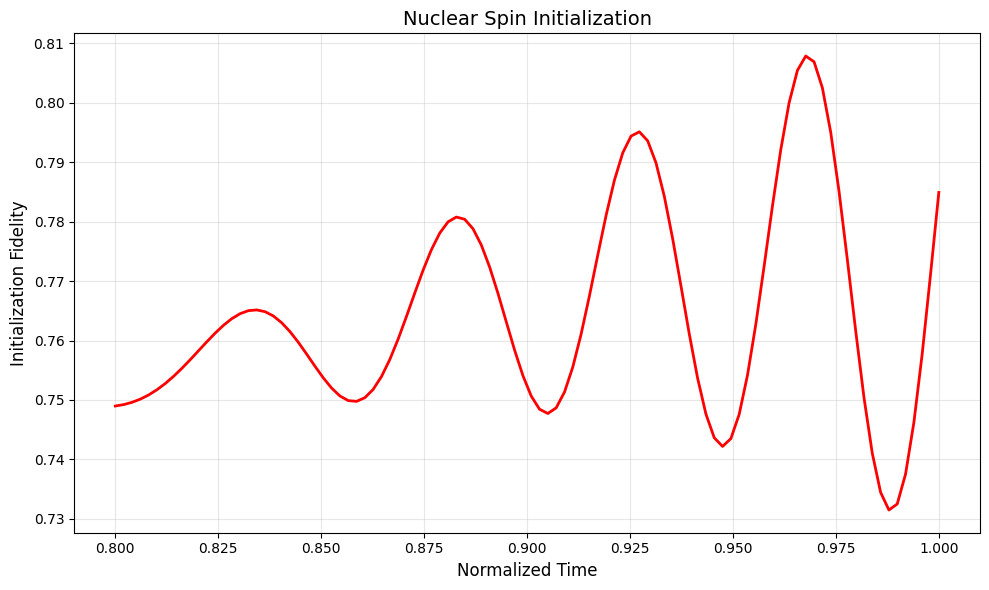

In [8]:

# Plot initialization results
plt.figure(figsize=(10, 6))
plt.plot(t2, SN, 'r-', linewidth=2)
plt.xlabel('Normalized Time', fontsize=12)
plt.ylabel('Initialization Fidelity', fontsize=12)
plt.title('Nuclear Spin Initialization', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()

print("="*60)
print(f"Total execution time: {time.time() - start_time:.2f} seconds")
print("="*60)
print("\nSimulation complete! Close the plot windows to exit.")

plt.show()